In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime

from one.api import ONE
from iblnm import vis

In [10]:
df_sessions = pd.read_parquet('metadata/sessions.pqt')

In [3]:
valid_targets = [
    'VTA',
    'SNc',
    'DR',
    'MR',
    'LC',
    'NBM',
    'SI',
    'PPT'
]

df_targets = df_sessions.explode(column='target').dropna(subset='target')
df_targets = df_targets.query('target.isin(@valid_targets) and NM != "none"')
df_targets['target_NM'] = df_targets.apply(lambda x: '-'.join([x['target'], x['NM']]), axis='columns')

/tmp/ipykernel_17995/588736987.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_mice = df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique()))


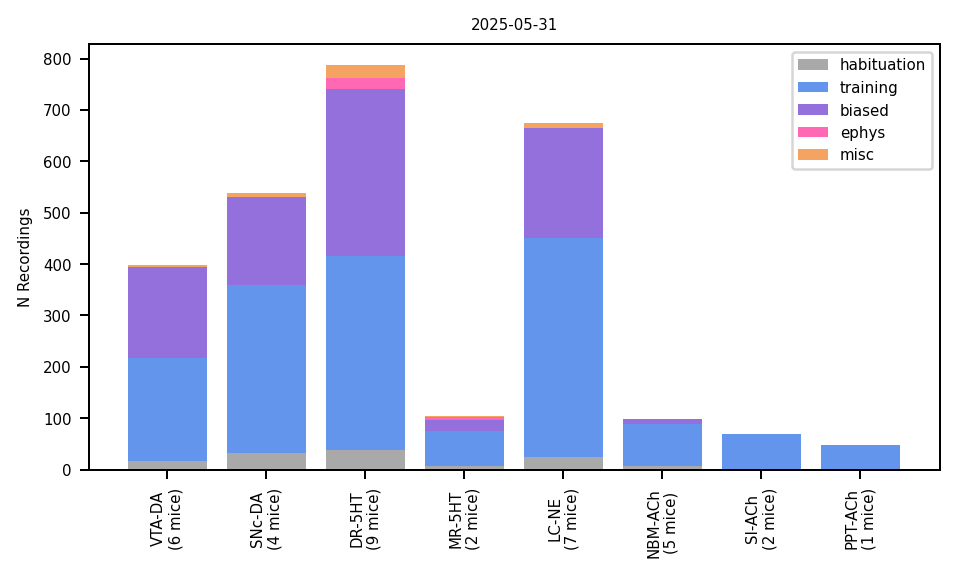

In [11]:
fig, ax = plt.subplots()
ax.set_title(datetime.today().strftime('%Y-%m-%d'))

positions = {
    'VTA-DA': 0,
    'SNc-DA': 1,
    'DR-5HT': 2,
    'MR-5HT': 3,
    'LC-NE': 4,
    'NBM-ACh': 5,
    'SI-ACh': 6,
    'PPT-ACh': 7
}

session_types = {
    'habituation': 'darkgray',
    'training': 'cornflowerblue',
    'biased': 'mediumpurple', 
    'ephys': 'hotpink',
    'misc':  'sandybrown'
}

df_n = df_targets.pivot_table(columns='session_type', index='target_NM', aggfunc='size', fill_value=0)
xpos = [positions[target_NM] for target_NM in df_n.index]
ypos = np.zeros(len(df_n))
width = 0.8
for session_type, color in session_types.items():
    n_sessions = df_n[session_type].values
    ax.bar(xpos, n_sessions, bottom=ypos, width=width, color=color, label=session_type)
    ypos += n_sessions
ax.set_xticks(list(positions.values()))
n_mice = df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique()))
ax.set_xticklabels(['%s\n(%d mice)' % (k, n_mice.loc[k]) for k in positions.keys()])
ax.set_xlim(right=max(positions.values()) + width)
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.arange(0, np.ceil(max(ypos) / 100) + 1) * 100)
ax.set_ylabel('N Recordings')
ax.legend()

# n_recordings = len(df_targets)
# n_sessions = len(df_targets.groupby('eid'))
# n_mice = len(df_targets.groupby('subject'))
# ax.set_title(f'{n_recordings} recordings, {n_sessions} sessions, {n_mice} mice')

fig.savefig('figures/sessions.svg')
vis.set_plotsize(w=12, h=6)

In [17]:
n_mice

target_NM
DR-5HT     9
LC-NE      7
MR-5HT     2
NBM-ACh    5
PPT-ACh    1
SI-ACh     2
SNc-DA     4
VTA-DA     6
dtype: int64

In [24]:
df_mice = pd.DataFrame(data=df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique())), columns=['N Mice'])

/tmp/ipykernel_31672/26313705.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mice = pd.DataFrame(data=df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique())), columns=['N Mice'])


/tmp/ipykernel_31672/2384004470.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_mice = df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique()))


In [29]:
n_mice.loc['VTA-DA']

np.int64(6)